# Noise Detection Algorithm

The data presented are measurements of a gaussian beam for varying beam-frequencies and distances. Due to technical difficulties, our measuring device would sometimes crash and provide us with completely noisy data, or data that was only half complete. Our intent was to automize the measuring process, by making the lab-computer automatically evaluate the data. In the case of faulty data, it was supposed to restart the measurement.

# Importing packages

In [1]:
# general
import numpy as np
import matplotlib.pyplot as plt
import re # to extract number in name
from pathlib import Path # to extract data from registry
import pandas as pd # data frames
from mpl_toolkits.axes_grid1 import make_axes_locatable #adjust colorbars to axis
from tkinter import Tcl # sort file names

In [2]:
# machine learning
# spli data
from sklearn.model_selection import train_test_split
# process data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# pipeline
from sklearn.pipeline import Pipeline
# model evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Importing and processing Data

## Importing samples

In [3]:
p=Path('.')
# list(path.glob'./*.dat') finds all data ".dat" data in entered directory
paths=list([x for x in p.iterdir() if x.is_dir() and x.name=='Measurements'][0].glob('./*.dat')) #use ** to also include subregistries
#remember to change name if directory name is changed
# generate lists
path_names=list(map(lambda x: x.name, paths)) # get path names
    # extract frequencies
pattern=re.compile(r"(\d+)")
freq_list=np.array([pattern.match(x).groups()[0] for x in path_names if x.startswith("Noise")==False]).astype(int)
freq_list=np.sort(freq_list)
    # sort paths
sorted_path_names=np.array(Tcl().call('lsort', '-dict', path_names)) # sorted path names
# hack for sorting lists from short too long (this should be the default)
duplicate_freqs=[x for x in np.unique(freq_list) if list(freq_list).count(x)!=1]
for duplis in duplicate_freqs:
    duplicate_indices=np.where(freq_list==duplis)
    for index in duplicate_indices[0][::-1][:-1]:
        backup=np.copy(sorted_path_names[index-1])
        sorted_path_names[index-1]=sorted_path_names[index]
        sorted_path_names[index]=backup
# Sort Noise-data
for index in np.where(np.array(list(map(lambda x:x.startswith("Noise"),sorted_path_names)))==True)[0][::-1][:-1]:
    backup=np.copy(sorted_path_names[index-1])
    sorted_path_names[index-1]=sorted_path_names[index]
    sorted_path_names[index]=backup
# sort
_,paths=zip(*sorted(zip([list(sorted_path_names).index(path_name) for path_name in path_names], paths)))
path_names=np.copy(sorted_path_names)
del sorted_path_names
#remember to change name if directory name is changed
data_dict={path.name: np.genfromtxt(path,skip_header=1)[:,2] for path in paths}
# add images
size=np.int(np.sqrt(len(data_dict[path_names[0]])))
data_dict["images"]=[data_dict[name].reshape((size,size)) for name in path_names]

## Assigning Features

In [4]:
# targets

# key targets 0=noise, 1=okay data, 2= good data
three_targets={
    '70GHz.dat':2,'70GHz-1.dat':2,
    '70GHz-2.dat':0,'75GHz.dat':2,
    '75GHz-1.dat':2,'80GHz.dat':2,
    '80GHz-1.dat':2,'85GHz.dat':2,
    '85GHz-1.dat':2,'85GHz-2.dat':0,
    '85GHz-3.dat':2,'85GHz-4.dat':0,
    '85GHz-5.dat':0,'85GHz-6.dat':0,
    '85GHz-7.dat':2,'85GHz-8.dat':1,
    '85GHz-9.dat':1,'85GHz-10.dat':2,
    '90GHz.dat':2,'90GHz-1.dat':2,
    '90GHz-2.dat':2,'90GHz-3.dat':1,
    '95GHz.dat':2,'95GHz-1.dat':2,
    '95GHz-2.dat':2,'95GHz-3.dat':0,
    '95GHz-4.dat':2,'95GHz-5.dat':2,
    '95GHz-6.dat':2,'95GHz-7.dat':1,
    '95GHz-8.dat':2,'95GHz-9.dat':0,
    '95GHz-10.dat':0,'95GHz-11.dat':0,
    '100GHz.dat':2,'100GHz-1.dat':2,
    '100GHz-2.dat':0,'105GHz.dat':2,
    '105GHz-1.dat':2,'105GHz-2.dat':0,
    '110GHz.dat':0,'110GHz-1.dat':0,
    '110GHz-2.dat':0,'Noise.dat':0,
    'Noise-1.dat':0 
}

## Forming Dictionary out of Data

In [5]:
# Create dictionary out of data
y=np.zeros(len(three_targets)).astype(int)
X=np.zeros((len(three_targets),len(data_dict[path_names[0]])))
size=np.int(np.sqrt(len(data_dict[path_names[0]])))
names=len(three_targets)*[""]
# counter
count=0
# format data correctly
for name in path_names:
    if name in three_targets:
        names[count]=name
        y[count]=three_targets[name]
        X[count,:]=data_dict[name]
        count+=1
    else:
        print("{} --- not yet labeled".format(name))
beam_data={"data_names":names,"data":X,"target":y,
           "target_names":["full noise","half_noise","no noise"],"images":[x.reshape((size,size)) for x in X]}

## Plotting all data

In [6]:
tes=np.arange(len(path_names))
print (len(tes[15:30]))
del tes

15


Yet to be labeled:
nothing


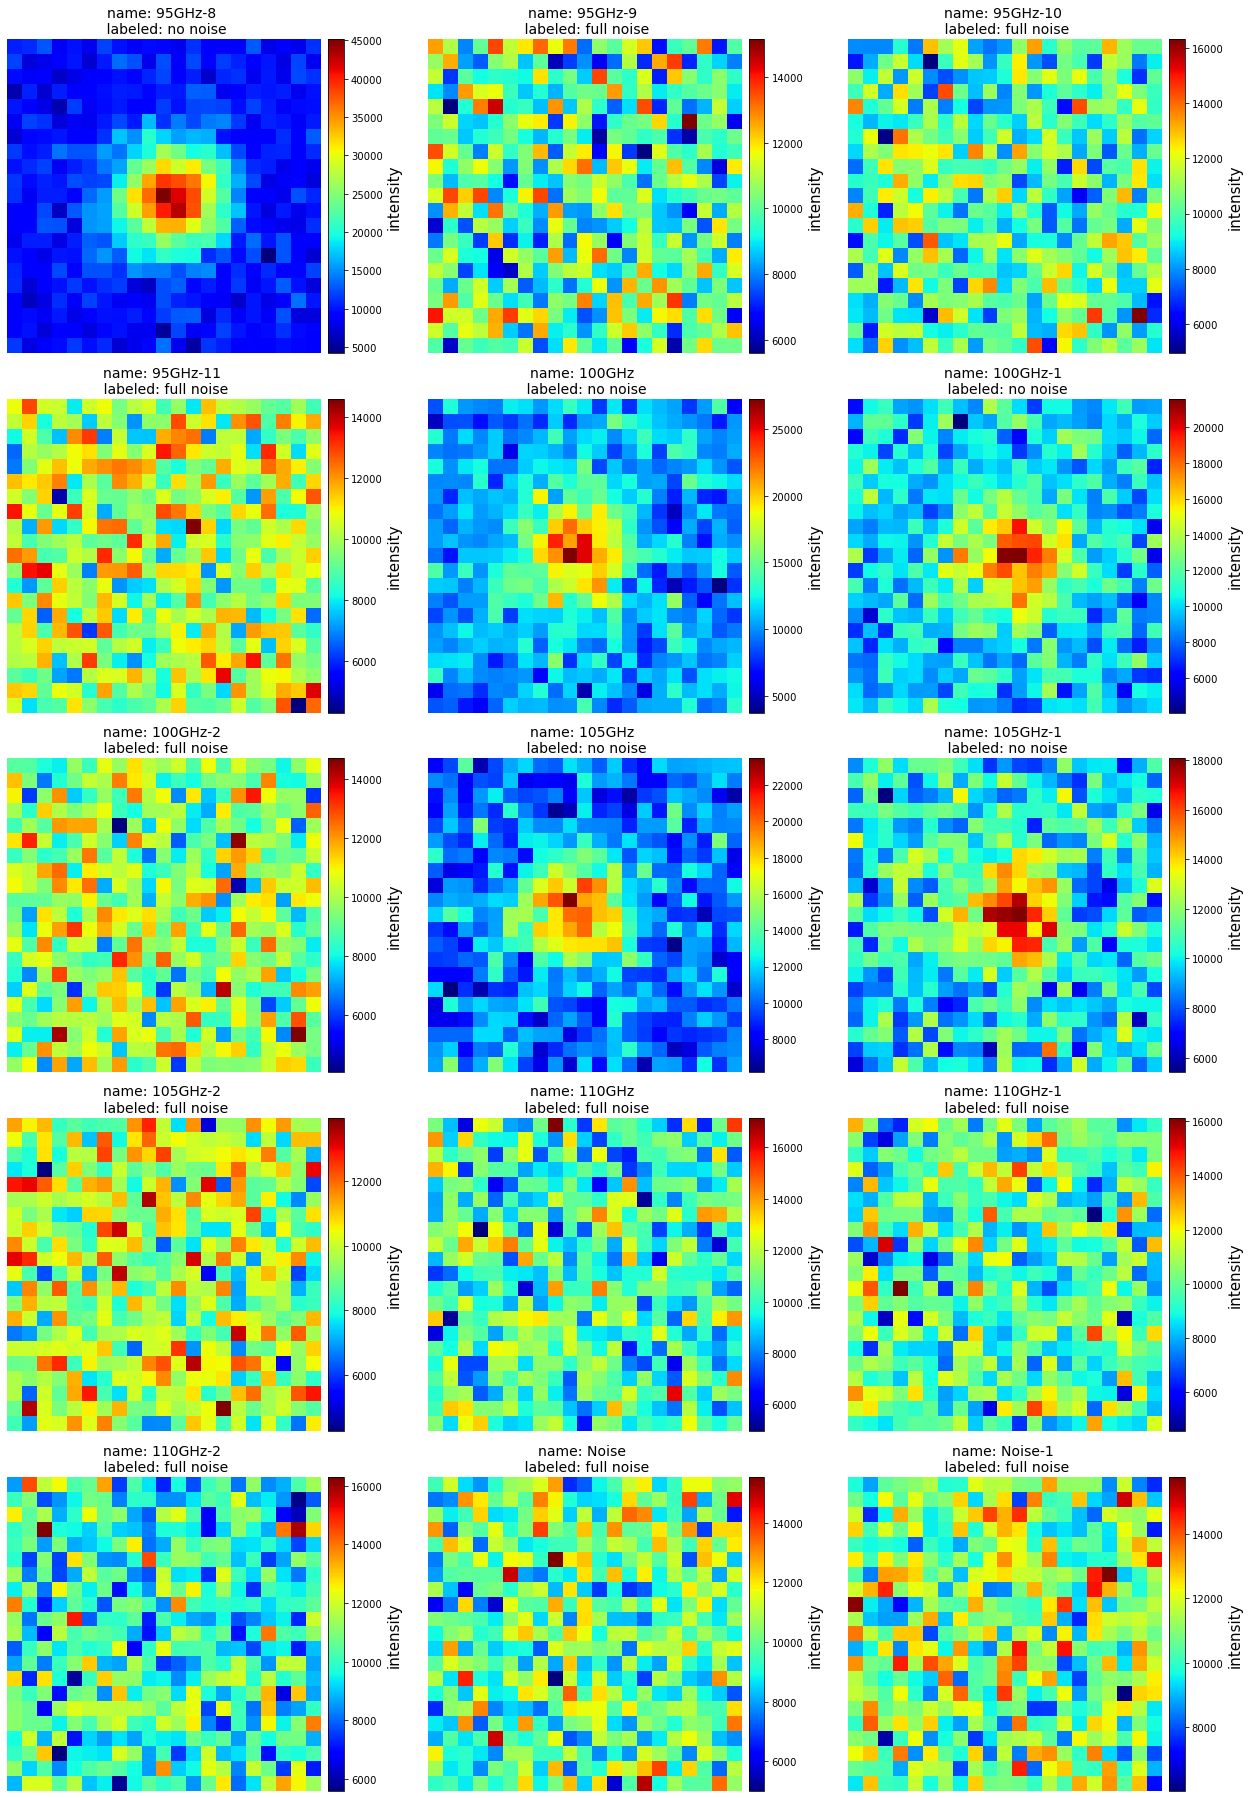

In [7]:
#all data
rows=int(len(path_names) / 3) + (len(path_names) % 3 > 0) # how many rows
# plot
fig = plt.figure(figsize=(18, 5*rows))
print("Yet to be labeled:")
for i,name in enumerate(path_names[30:]):
    boolean=False # check if something has to be labeled:
    ax=plt.subplot(rows,3,i+1)
    ax.set_axis_off() # hide axis
    im=ax.imshow(data_dict["images"][list(data_dict.keys()).index(name)],cmap='jet', interpolation='nearest')
    if name in beam_data["data_names"]:
        ax.set_title("name: {} \n labeled: {}".format(name[:-4],beam_data["target_names"][beam_data["target"][list(beam_data["data_names"]).index(name)]]),fontsize=14)
    else:
        boolean=True
        ax.set_title("name: {}\n not labeled yet".format(name),color="red")
        print("'{}'".format(name))
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)
if boolean==False: print("nothing")
plt.tight_layout()

# for export
#plt.savefig("Images/ml-databatch-3.png")

# Feature Engineering

## rescaling

In [8]:
def rescale_local_max(X):
    return [X[i]/maxi for i,maxi in enumerate(np.amax(X,axis=1))]

## rotating for symmetrical prediction (generalization)

In this dataset, the transition to half_noise always occurs from no_noise in the top region to full_noise in the bottom region. To generalize the algorithm for other problems, the half data will now be rotated (Note that this may produce too optimistic evaluations of model predictions for this class).

For even further generalization, all data in 2D representation can be repositioned to have their peak in the center. This way, dispositions of the curve location would not need to be considered within the model, which could improve not only generalization performace, but also general performance in general.

In [9]:
# rescale
X_total=np.array(rescale_local_max(beam_data["data"]))
y_total=np.array(beam_data["target"])

In [10]:
# rescale
X_total=rescale_local_max(beam_data["data"])
# take half data
X_half_noise=np.array(X_total)[np.where(beam_data["target"]==1)]
# X_data in total
X_added=np.zeros((X_half_noise.shape[0]*3,X_half_noise.shape[1]))
for i in range(X_half_noise.shape[0]):
        X_added[3*i,:]=np.rot90(X_half_noise[i].reshape((size,size))).flatten()
        X_added[3*i+1,:]=np.rot90(X_added[3*i,:].reshape((size,size))).flatten()
        X_added[3*i+2,:]=np.rot90(X_added[3*i+1,:].reshape((size,size))).flatten()
X_total=np.vstack((X_total,X_added))
y_total=np.concatenate((beam_data["target"],[1]*X_half_noise.shape[0]*3))

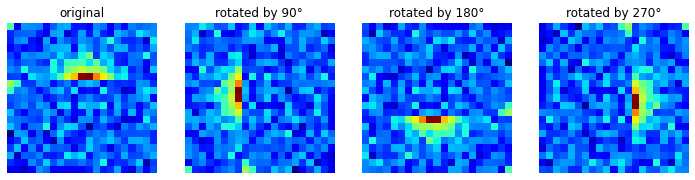

In [11]:
# provide example of rotated data
fig=plt.figure(figsize=(10,2.5))
ax=plt.subplot(1,4,1)
ax.imshow(X_half_noise[3,:].reshape((size,size)),cmap="jet")
ax.set_title("original")
ax.set_axis_off() # hide axis
for i in range(3):
    ax=plt.subplot(1,4,i+2)
    ax.imshow(X_added[9+i,:].reshape((size,size)),cmap="jet")
    ax.set_title("rotated by {}°".format(90*(i+1)))
    ax.set_axis_off() # hide axis
plt.tight_layout()
plt.savefig("Images/rotated-maps.png")

In [12]:
# split sets
X_train, X_test, y_train, y_test = train_test_split(X_total,y_total, stratify=y_total, random_state=0)

# Machine Learning (applying PCA + knn)

In [13]:
np.array(X_train).shape

(42, 441)

In this application we have few samples (42) and many features (441). To reduce the number of features, we apply Prinicipal Component Analysis (PCA), to reduce the dimension in feature space (Here from 221 to 2) and therefore improve the performance of our alogorithm. We use the k-neighbours classifier (knn), as it performs particulary well on small sample sizes.

## PCA and it's data rescaling results

In [14]:
# scale to mean=0, std=1
scaler = StandardScaler()
# fit scaling
scaler.fit(X_train)
# apply scaling
scaled_X_train=scaler.transform(X_train)
# n_components=amount of principal components
pca = PCA(n_components=2) # n_components=0.95 alternatively
# fit PCA model to beast cancer data
pca.fit(scaled_X_train)
# transform
pca_X_train = pca.transform(scaled_X_train)

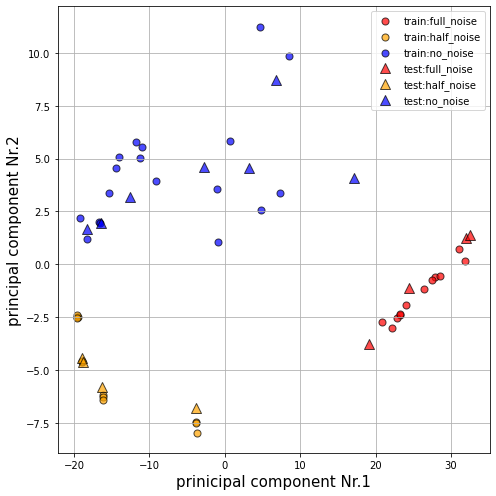

In [15]:
# Create data
# PCA on train data
g0 = pca_X_train[np.where(y_train==0)]
g1 = pca_X_train[np.where(y_train==1)]
g2 = pca_X_train[np.where(y_train==2)]

train_data = (g0, g1, g2)
colors = ("red","orange","blue")
groups = ("full_noise", "half_noise","no_noise")
train_marker=("o")
# PCA on test data
# transform
scaled_X_test=scaler.transform(X_test)
pca_X_test = pca.transform(scaled_X_test)
# # # # #
h0 = pca_X_test[np.where(y_test==0)]
h1 = pca_X_test[np.where(y_test==1)]
h2 = pca_X_test[np.where(y_test==2)]
test_data = (h0, h1, h2)
test_marker=("^")
# Create plot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, )
# plot train-transform
for data, color, group in zip(train_data, colors, groups):
    x =data[:,0]
    y =data[:,1]
    ax.scatter(x, y, alpha=0.7, c=color, edgecolors='black', s=50, label="train:"+group, marker=train_marker)
# plot test-transform
for data, color, group in zip(test_data, colors, groups):
    x =data[:,0]
    y =data[:,1]
    ax.scatter(x, y, alpha=0.7, c=color, edgecolors='black', s=100, label="test:"+group, marker=test_marker)
    # labels
#plt.title('PCA-transformed plot')
plt.xlabel("prinicipal component Nr.1",fontsize=15)
plt.ylabel("principal component Nr.2",fontsize=15)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.savefig("Images/PCA_map.png", bbox_inches='tight')
plt.show()

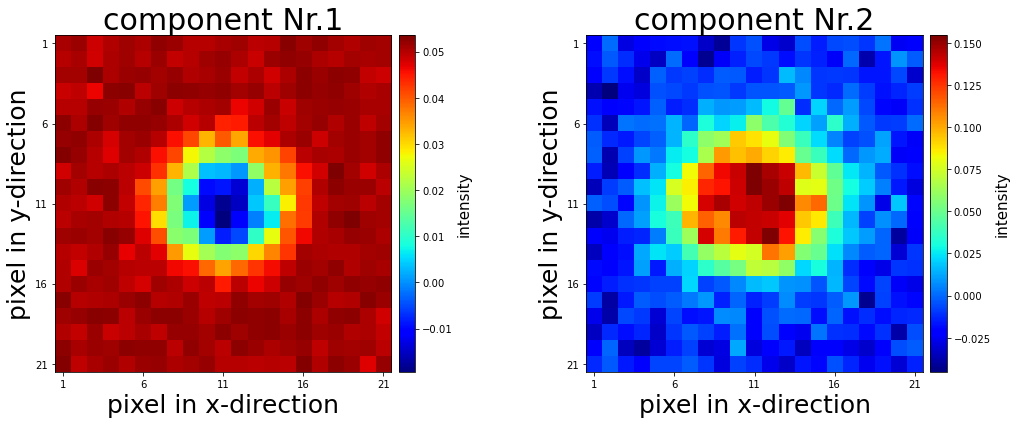

In [45]:
# plot components
fig, axes = plt.subplots(1, 2,figsize=(15,6))
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    im=ax.imshow(component.reshape((size,size)),cmap='jet',interpolation="nearest")
    ax.set_title("component Nr.{}".format(i+1),fontsize=30)
    ax.set_xlabel("pixel in x-direction",fontsize=25)
    ax.set_ylabel("pixel in y-direction",fontsize=25)
    # tick labels
    ax.set_xticklabels(range(1,size+1,5))
    ax.set_yticklabels(range(1,size+1,5))
    ax.set_xticks(range(0,size,5))
    ax.set_yticks(range(0,size,5))
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)
#fig.suptitle('PCA component weights', fontsize=20)
plt.tight_layout()
plt.savefig("Images/PCA-componenets.png", bbox_inches='tight')

## Creating and fitting pipeline

because of small sample-size, no parameter optimization will be conducted 
(as splitting the data in another validation set would reduce the already small test set)

In [17]:
# create pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("component_analyzer", PCA(n_components=2)),
                 ("classifier", KNeighborsClassifier(n_neighbors=1))])# fitting
pipe.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('component_analyzer', PCA(n_components=2)),
                ('classifier', KNeighborsClassifier(n_neighbors=1))])

## Algorithm performance

### General evaluation via stratified KFold cross validation

stratified makes sure that all classes are represented in each training set. Shuffle makes sure, that the data is shuffled before it is split and is only necessary when the data is sorted.

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
      cross_val_score(pipe, X_total, y_total, cv=kfold)))

Cross-validation scores:
[1.         1.         0.90909091 1.         1.        ]


### confusion matrix shows, how test samples were classified

In [19]:
# cross calidation confusion matrix
splits=list(kfold.split(X_total,y_total))
for i,split in enumerate(splits):
    pipe.fit(X_total[split[0]],y_total[split[0]])
    print("Split Nr.{}:\n{}\n".format(i,confusion_matrix(pipe.predict(X_total[split[1]]),y_total[split[1]])))

Split Nr.0:
[[4 0 0]
 [0 3 0]
 [0 0 5]]

Split Nr.1:
[[3 0 0]
 [0 4 0]
 [0 0 5]]

Split Nr.2:
[[3 0 1]
 [0 3 0]
 [0 0 4]]

Split Nr.3:
[[3 0 0]
 [0 3 0]
 [0 0 5]]

Split Nr.4:
[[3 0 0]
 [0 3 0]
 [0 0 5]]



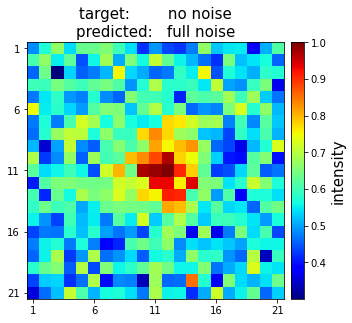

In [55]:
# show incorrectly classified beam map

i=2 # index with non-diagonal confusion matrix
pipe.fit(X_total[splits[i][0]],y_total[splits[i][0]])
false_pred=pipe.predict(X_total[splits[i][1]])[pipe.predict(X_total[splits[i][1]])!=y_total[splits[i][1]]][0]
beam_data["target_names"][false_pred]
# index
index=splits[i][1][np.where(pipe.predict(X_total[splits[i][1]])!=y_total[splits[i][1]])]
# plot
plt.figure(figsize=(5,5.5))
ax=plt.subplot(1,1,1)
# find target and prediction
target = beam_data["target_names"][y_total[index][0]]
prediction = beam_data["target_names"][false_pred]
# set title accordingly
ax.set_title(f"{'target:':<13}{target:>10}\n{'predicted:':<13}{prediction:>10}",
            fontsize=15)
ax.imshow(X_total[index].reshape((size,size)), 
          cmap="jet")
# tick labels
ax.set_xticklabels(range(1,size+1,5))
ax.set_yticklabels(range(1,size+1,5))
ax.set_xticks(range(0,size,5))
ax.set_yticks(range(0,size,5))
#adjust colorbar to plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar=plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('intensity',fontsize=15)

plt.tight_layout()
plt.savefig("Images/false-prediction.png", bbox_inches='tight')

## Evaluation of one singular split 

### predict test set

In [22]:
predictions=pipe.predict(X_test)

In [23]:
print(predictions)

[2 1 2 2 1 2 0 2 0 2 1 0 0 0 1]


In [24]:
print("confusion matrix:\n{}".format(confusion_matrix(y_test,predictions)))

confusion matrix:
[[4 0 0]
 [0 4 0]
 [1 0 6]]


### falsely classified in test data

2 0


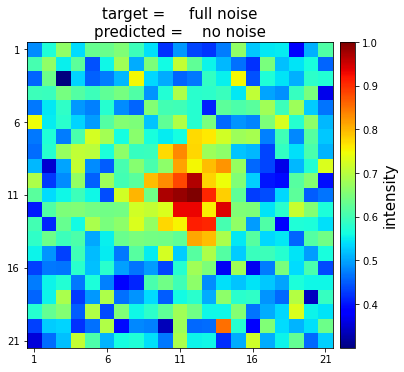

In [46]:
# collect indices
index=[]
predictions=pipe.predict(X_test)
for i in range(len(y_test)):
    if y_test[i]!=predictions[i]:
        print(y_test[i],predictions[i])
        index.append(i)
    
# show false predictions in test_data
rows=int(len(index) / 3) + (len(index) % 3 > 0) # how many rows
# plot
fig = plt.figure(figsize=(20, 5*rows+1))
for i,ind in enumerate(index):
    ax.set_axis_off() # hide axis
    ax=plt.subplot(rows,3,i+1)
    im=ax.imshow(X_test[ind].reshape((size,size)),cmap='jet', interpolation='nearest')
    # find target and prediction
    target = beam_data["target_names"][predictions[ind]]
    prediction = beam_data["target_names"][y_test[ind]]
    # set title accordingly
    ax.set_title(f"{'target:':<13}{target:>10}\n{'predicted:':<13}{prediction:>10}",fontsize=15)
    # tick labels
    ax.set_xticklabels(range(1,size+1,5))
    ax.set_yticklabels(range(1,size+1,5))
    ax.set_xticks(range(0,size,5))
    ax.set_yticks(range(0,size,5))
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)

### falsely classified in train data (unreasonable here, due to knn: n_neighbours = 1)

In [47]:
# collect indices
index=[]
predictions=pipe.predict(X_train)
for i in range(len(y_train)):
    if y_train[i]!=predictions[i]:
        print((y_train[i],predictions[i]))
        index.append(i)
        
# show false predictions in train data
rows=int(len(index) / 3) + (len(index) % 3 > 0) # how many rows
# plot
fig = plt.figure(figsize=(20, 5*rows+1))
for i,ind in enumerate(index):
    ax.set_axis_off() # hide axis
    ax=plt.subplot(rows,3,i+1)
    im=ax.imshow(X_train[ind].reshape((size,size)),cmap='jet', interpolation='nearest')
    target = beam_data["target_names"][predictions[ind]]
    prediction = beam_data["target_names"][y_train[ind]]
    # set title accordingly
    ax.set_title(f"{'target:':<13}{target:>10}\n{'predicted:':<13}{prediction:>10}",fontsize=15)
    # tick labels
    ax.set_xticklabels(range(1,size+1,5))
    ax.set_yticklabels(range(1,size+1,5))
    ax.set_xticks(range(0,size,5))
    ax.set_yticks(range(0,size,5))
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)

<Figure size 1440x72 with 0 Axes>

# Additional plots for thesis

## 3 categories

In [27]:
names=["75GHz.dat","105GHz-2.dat","85GHz-8.dat"]
indici=[beam_data["data_names"].index(name) for name in names]
maps=[beam_data["images"][ind] for ind in indici]

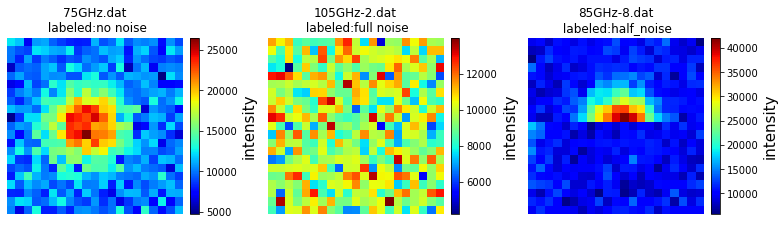

In [28]:
fig=plt.figure(figsize=(11,8))
for i,map_i in enumerate(maps,0):
    ax=plt.subplot(1,3,i+1)
    ax.set_axis_off() # hide axis
    ax.set_title("{}\n labeled:{}".format(names[i],beam_data["target_names"][beam_data["target"][indici][i]]))
    #plot
    im=ax.imshow(map_i,cmap="jet")
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)
plt.tight_layout()
plt.savefig("Images/3-categories.png", bbox_inches='tight')

## questionable labels

In [29]:
names=["85GHz.dat","85GHz-1.dat","95GHz-5.dat"]
indici=[beam_data["data_names"].index(name) for name in names]
maps=[beam_data["images"][ind] for ind in indici]

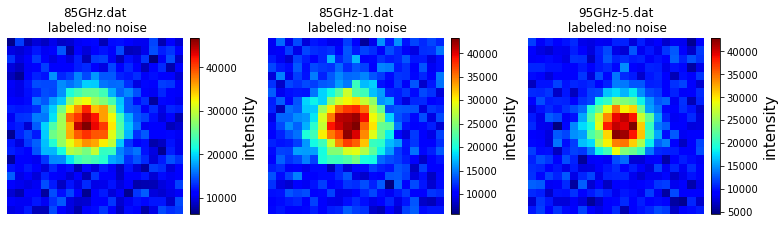

In [30]:
fig=plt.figure(figsize=(11,8))
for i,map_i in enumerate(maps,0):
    ax=plt.subplot(1,3,i+1)
    ax.set_axis_off() # hide axis
    ax.set_title("{}\n labeled:{}".format(names[i],beam_data["target_names"][beam_data["target"][indici][i]]))
    #plot
    im=ax.imshow(map_i,cmap="jet")
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=15)
plt.tight_layout()
plt.savefig("Images/questionable-labels.png", bbox_inches='tight')